...
Данные проанализированы, графики построены, обучение запущено. Можно демонстрировать итоги работы. 

\- Так-так, говоришь, модель уже готова? За один день? Ну показывай.

Поначалу Коля явно был полон скептицизма. Спустя 10 минут недоверия в его голосе только прибавилось, но развязка оказалась крайне неожиданной для вас.

\- И данные тебе никто не помогал собирать и обрабатывать? И гиперпараметры ты применять умеешь? Хм... Устроим-ка тебе последнюю проверку. Вчера пришли новые данные из БКИ о кредитной истории клиентов. Даю тебе два дня. Можешь брать себе в помощники любого из нашего отдела, я предупрежу ребят. 

(с) Проект 5. Компьютер говорит «Нет»




# Описание проекта
### Задача 
Задача – построить наиболее эффективную модель кредитного скоринга для вторичных клиентов банка.

Для решения задачи понадобится пройти следующие этапы:

1. Первичный анализ данных
2. Первичная обработка данных
3. Наивная модель
4. Подбор гиперпараметров
5. Вторичная обработка данных
6. Анализ значимости признаков
7. Прочие модели

### Описание полей
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [1]:
import random

from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error


RANDOM_SEED = 42

In [2]:
data_dir = './'

train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
sample = pd.read_csv(data_dir + 'sample_submission.csv')



In [3]:
def train_model(model, X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.3)
    
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    
    print('accuracy_score: ', accuracy_score(y_valid, y_pred))
    print('f1_score: ', f1_score(y_valid, y_pred))
    print('recall_score: ', recall_score(y_valid, y_pred))
    print('MSE: ', mean_squared_error(y_valid, y_pred))
    print('roc_auc_score: ', roc_auc_score(y_valid, probs))

### 1. Первичный анализ данных

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


Осмотрим и заполним пропуски education

In [7]:
train.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [8]:
def replace_nan(df, col):
    if (df[col].dtypes == np.dtype('O')):
        prob = df[col].value_counts(normalize = True)
        ind = df[df[col].isna()==True].index
        fill_list = pd.Series(random.choices(prob.index, prob, k=df[col].isna().sum()))
        fill_list.index = ind
        return df[col].fillna(fill_list)
    else:
        median = df[col].median()
        return df[col].fillna(median)

#train['education'] = replace_nan(train, 'education')

Посмотрим подробнее на колонки.

In [9]:
train.client_id.value_counts()

2049      1
85187     1
85507     1
83458     1
87552     1
         ..
101156    1
107297    1
109344    1
21279     1
6141      1
Name: client_id, Length: 73799, dtype: int64

Повторов нет.

In [10]:
train.app_date.value_counts()

18MAR2014    1018
17MAR2014     911
19MAR2014     909
31MAR2014     904
07APR2014     882
             ... 
20APR2014     243
07JAN2014     228
03JAN2014     193
02JAN2014     137
01JAN2014      43
Name: app_date, Length: 120, dtype: int64

Интересная колонка. Надо будет из нее извлечь дни, месяцы, год заявки

In [11]:
train.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

Категориальная переменная.

<AxesSubplot:xlabel='education', ylabel='count'>

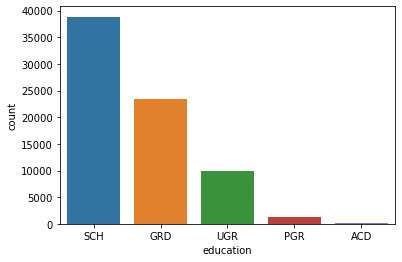

In [12]:
sns.countplot(x='education', data=train)

In [13]:
train.sex.value_counts()

F    41562
M    32237
Name: sex, dtype: int64

Бинарная переменная.

In [14]:
train.age.value_counts()

31    2727
28    2705
30    2693
29    2659
27    2645
26    2528
32    2501
34    2395
33    2314
35    2259
25    2202
36    2159
37    2118
38    2088
39    2082
42    1973
40    1932
24    1873
41    1857
43    1770
44    1690
23    1509
45    1487
50    1424
47    1418
46    1407
48    1404
52    1387
51    1385
53    1326
54    1326
49    1304
55    1230
56    1114
57    1040
22     937
59     925
58     881
60     851
21     849
61     661
62     576
63     477
64     449
65     422
66     309
67     248
68     165
69      81
70      32
71       3
72       2
Name: age, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

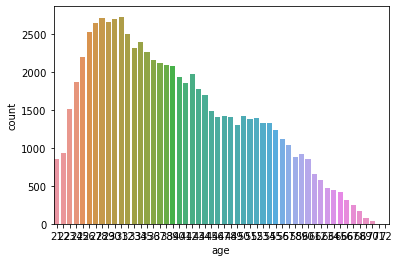

In [15]:
sns.countplot(x='age', data=train)

Числовая переменная.

In [16]:
train.car.value_counts()

N    49832
Y    23967
Name: car, dtype: int64

Бинарная переменная.

In [17]:
train.car_type.value_counts()

N    59791
Y    14008
Name: car_type, dtype: int64

Бинарная переменная.

In [18]:
train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

<AxesSubplot:xlabel='decline_app_cnt', ylabel='count'>

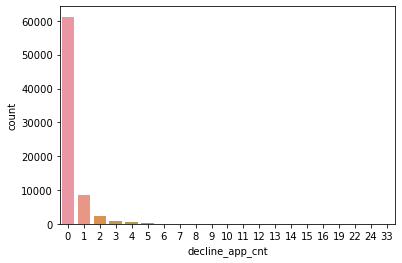

In [19]:
sns.countplot(x='decline_app_cnt', data=train)

Числовая переменная. Длинный хвост справа

In [20]:
train.good_work.value_counts()

0    61630
1    12169
Name: good_work, dtype: int64

Бинарная переменная.

In [21]:
train.score_bki.value_counts()

-1.775263    352
-2.225004    296
-2.104211    288
-2.169664    258
-1.920823    185
            ... 
-1.400832      1
-1.824425      1
-2.081890      1
-2.216073      1
-2.296371      1
Name: score_bki, Length: 69096, dtype: int64

<AxesSubplot:>

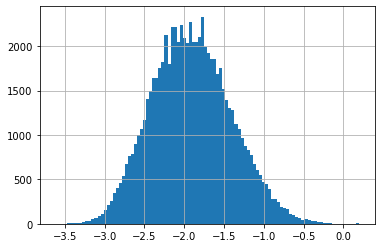

In [22]:
train.score_bki.hist(bins=100)

In [23]:
train.score_bki.mean()

-1.9047236272216417

Числовая переменная. Предварительно обработана. Матожидание где-то в районе -2 (среднее в -1.9)

In [24]:
train.bki_request_cnt.value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
22        4
28        4
25        2
26        2
27        2
32        2
41        1
46        1
45        1
29        1
36        1
34        1
33        1
53        1
Name: bki_request_cnt, dtype: int64

<AxesSubplot:xlabel='bki_request_cnt', ylabel='count'>

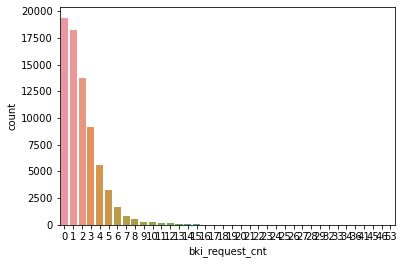

In [25]:
sns.countplot(x='bki_request_cnt', data=train)

Числовая переменная. И вновь хвост справа

In [26]:
train.region_rating.value_counts()

50    27523
60    16075
40    12027
80    11469
70     6199
30      300
20      206
Name: region_rating, dtype: int64

<AxesSubplot:xlabel='region_rating', ylabel='count'>

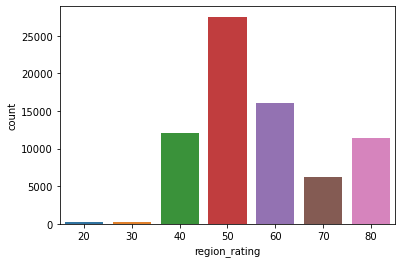

In [27]:
sns.countplot(x='region_rating', data=train)

Категориальная переменная. Предварительно закодирована

In [28]:
train.home_address.value_counts()

2    39956
1    32585
3     1258
Name: home_address, dtype: int64

<AxesSubplot:xlabel='home_address', ylabel='count'>

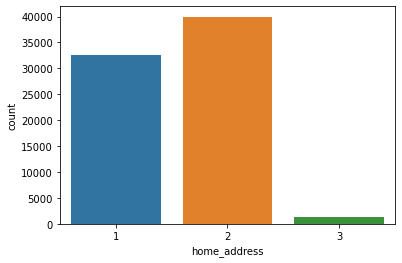

In [29]:
sns.countplot(x='home_address', data=train)

Категориальная переменная. 

In [30]:
train.work_address.value_counts()

3    44959
2    20506
1     8334
Name: work_address, dtype: int64

<AxesSubplot:xlabel='work_address', ylabel='count'>

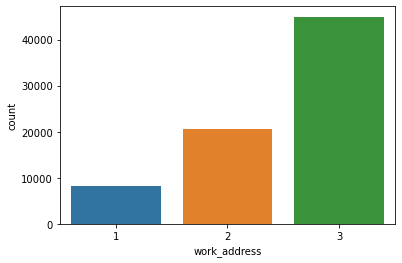

In [31]:
sns.countplot(x='work_address', data=train)

Категориальная переменная. 

In [32]:
train.income.value_counts()

30000     7009
25000     6061
20000     5471
40000     4935
50000     4470
          ... 
30059        1
85260        1
60600        1
208000       1
426000       1
Name: income, Length: 966, dtype: int64

<AxesSubplot:>

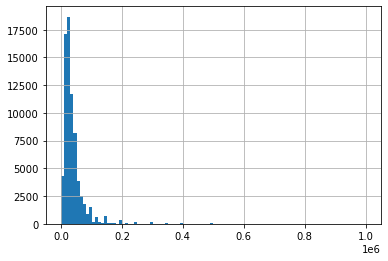

In [33]:
train.income.hist(bins=100)

Числовая переменная с длинным хвостом справа

In [34]:
train.sna.value_counts()

1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64

<AxesSubplot:xlabel='sna', ylabel='count'>

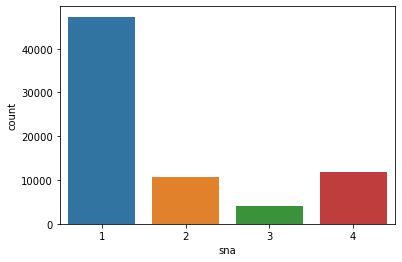

In [35]:
sns.countplot(x='sna', data=train)

Категориальная переменная. Предварительно закодирована

In [36]:
train.first_time.value_counts()

3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64

<AxesSubplot:xlabel='first_time', ylabel='count'>

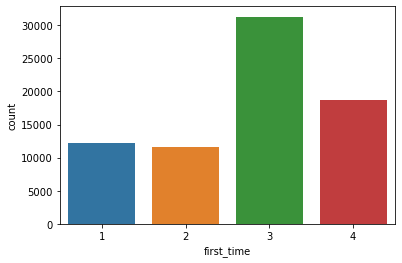

In [37]:
sns.countplot(x='first_time', data=train)

Категориальная переменная. Предварительно закодирована

In [38]:
train.foreign_passport.value_counts()

N    62733
Y    11066
Name: foreign_passport, dtype: int64

<AxesSubplot:xlabel='foreign_passport', ylabel='count'>

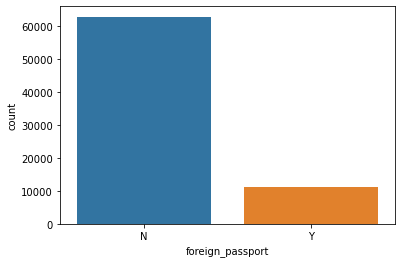

In [39]:
sns.countplot(x='foreign_passport', data=train)

Бинарная переменная.

In [40]:
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

Данных об одном классе из целевой переменной значительно больше, чем о втором, этот дисбаланс надо будет иметь в виду.

Итого имеем следующее разделение на бинарные, категориальные и числовые значения (помним, что еще есть колонка app_date):

In [41]:


bin_cols = ['sex','car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address','work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'region_rating', 'score_bki']

#app_date

### 2. Первичная обработка данных

Для корректной обработки признаков объединяем train и test в один датасет

В тестовых данных отсутствуют значения default, поэтому пока заполняем константой

In [42]:
train['sample'] = 1   # помечаем тренировочные данные
test['sample'] = 0    # помечаем тестовые данные

test['default'] = -1

df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Бинарные колонки кодируем при помощи LabelEncoder

In [43]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,1
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,1
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,1
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,1
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,1


education кодируем в цифру.

In [44]:
def code_education(string):
    if string == "SCH": return 0
    elif string == "GRD": return 1
    elif string == "UGR": return 2
    elif string == "PGR": return 3
    elif string == "ACD": return 4
    else: return 5 #на случай "а вдруг пропуски или новые ззначения?"" 

df['education'] = df['education'].apply(code_education)

In [45]:
df.education.value_counts()

0    57998
1    34768
2    14748
3     1865
5      478
4      291
Name: education, dtype: int64

Извлекем максимум информации из app_date

In [46]:
df['app_date'] = pd.to_datetime(df.app_date)

In [47]:
df['weekday'] = df.app_date.apply(lambda x: x.weekday())
#df['day'] = df.app_date.apply(lambda x: x.day)
#df['month'] = df.app_date.apply(lambda x: x.month)
#df['year'] = df.app_date.apply(lambda x: x.year)

df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,weekday
0,25905,2014-02-01,0,1,62,1,1,0,0,-2.008753,...,50,1,2,18000,4,1,0,0,1,5
1,63161,2014-03-12,0,0,59,0,0,0,0,-1.532276,...,50,2,3,19000,4,1,0,0,1,2
2,25887,2014-02-01,0,1,25,1,0,2,0,-1.408142,...,80,1,2,30000,1,4,1,0,1,5
3,16222,2014-01-23,0,0,53,0,0,0,0,-2.057471,...,50,2,3,10000,1,3,0,0,1,3
4,101655,2014-04-18,1,1,48,0,0,0,1,-1.244723,...,60,2,3,30000,1,4,1,0,1,4


In [48]:
# Логарифмирование "хвостатых переменных" среди численных
num_cols_tails = ['income', 'decline_app_cnt', 'bki_request_cnt']

for col in num_cols_tails:
    df[col] = np.log(df[col] + 1)

In [49]:
# Стандартизация численных переменных
df[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]),
                              columns=num_cols)

In [50]:
# обработка категориальных признаков
#cat_cols = ['education', 'home_address','work_address', 'region_rating', 'sna', 'first_time']
df = pd.get_dummies(df, columns=cat_cols)

In [51]:
cat_cols

['education', 'home_address', 'work_address', 'sna', 'first_time']

### 3. Наивная модель

Разделим обратно на train и test

In [52]:
df_train = df.query('sample == 1').drop(['sample'], axis=1)
df_test = df.query('sample == 0').drop(['sample'], axis=1)

In [53]:
X = df_train.drop(columns=['default', 'client_id', 'app_date'])
y = df_train['default']

Построим модель логистической регрессии

In [54]:
model = LogisticRegression(max_iter = 1000)
model.fit(X, y)

train_model(model, X, y)

accuracy_score:  0.8731255645889793
f1_score:  0.044232732221844165
recall_score:  0.023381294964028777
MSE:  0.12687443541102078
roc_auc_score:  0.7352145824662585


Здравствуй undersampling...

А теперь проверим качество модели на сбалансированных данных

In [55]:
df_train.default.value_counts()


0    64427
1     9372
Name: default, dtype: int64

In [56]:
df_train_1= df_train[df_train.default == 1]
df_train_0= df_train[df_train.default == 0]
df_train_01= df_train[:9372]

frames = [df_train_01, df_train_1]

df_train_undersampling = pd.concat(frames)

In [57]:
X = df_train_undersampling.drop(columns=['default', 'client_id', 'app_date','weekday'])
y = df_train_undersampling['default']

In [58]:
model = LogisticRegression(max_iter = 2000)
model.fit(X, y)

train_model(model, X, y)

accuracy_score:  0.6749644381223329
f1_score:  0.7266746411483253
recall_score:  0.7675300063171194
MSE:  0.32503556187766713
roc_auc_score:  0.7322295679223976


Модель начала обучаться и показывает неплохие результаты.
 
Посмотрим на значимость 

<AxesSubplot:>

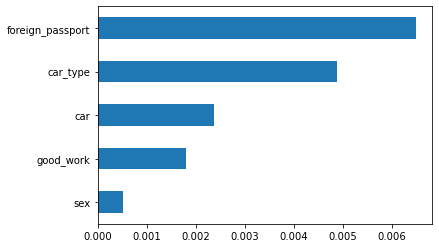

In [78]:
imp_cat = Series(mutual_info_classif(df_train_undersampling[bin_cols], df_train_undersampling['default'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')



In [60]:
df_test = df_test.drop(columns=['default', 'client_id', 'app_date','weekday'])

In [61]:
df_test

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
73799,1,-0.889859,1,1,-0.418815,0,-0.735587,0.770563,-0.516704,0.680425,...,1,0,1,0,0,0,0,0,0,1
73800,0,-0.021654,0,0,4.539989,0,0.800039,0.333797,-0.516704,-2.624624,...,1,0,0,0,0,1,0,0,1,0
73801,1,0.933372,1,1,-0.418815,0,0.426908,-0.281790,-0.516704,-0.052834,...,1,0,1,0,0,0,0,0,1,0
73802,1,1.454295,0,0,-0.418815,0,-0.940432,-0.281790,-1.282058,-0.868125,...,1,0,1,0,0,0,0,0,1,0
73803,0,-0.108474,0,0,-0.418815,0,-1.167347,-1.334144,1.779355,1.937123,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,-0.195295,0,0,1.499512,0,0.319505,0.770563,-0.516704,-1.047783,...,0,1,0,0,0,1,1,0,0,0
110144,0,2.148860,1,1,-0.418815,0,-0.779436,0.770563,0.248649,2.670397,...,1,0,1,0,0,0,0,0,0,1
110145,1,-0.716218,0,0,2.621662,0,1.929901,-0.281790,-0.516704,0.942139,...,1,0,0,0,0,1,0,1,0,0
110146,0,-1.063501,0,0,1.499512,0,1.325890,0.333797,1.779355,-0.052834,...,0,1,1,0,0,0,1,0,0,0


In [62]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 73799 to 110147
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               36349 non-null  int64  
 1   age               36349 non-null  float64
 2   car               36349 non-null  int64  
 3   car_type          36349 non-null  int64  
 4   decline_app_cnt   36349 non-null  float64
 5   good_work         36349 non-null  int64  
 6   score_bki         36349 non-null  float64
 7   bki_request_cnt   36349 non-null  float64
 8   region_rating     36349 non-null  float64
 9   income            36349 non-null  float64
 10  foreign_passport  36349 non-null  int64  
 11  education_0       36349 non-null  uint8  
 12  education_1       36349 non-null  uint8  
 13  education_2       36349 non-null  uint8  
 14  education_3       36349 non-null  uint8  
 15  education_4       36349 non-null  uint8  
 16  education_5       36349 non-null  u

In [63]:
probs = model.predict_proba(df_test) # залем результаты на кагл. посчитаем текущий рейтинг


In [64]:
submission = pd.DataFrame(probs)

In [65]:
sub = pd.DataFrame({'client_id': df.query('sample == 0').drop(['sample'], axis=1).client_id.to_list(), 
                    'default': submission[1].to_list()})
sub.to_csv('sub4.csv', index=False)

### 4. Гиперпараметры


In [80]:
# разделяем на тренеровочные и валидационные данные
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

In [81]:
# Подбор лучших гиперпараметров для модели

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 464.15888336127773


In [82]:
# описываем и обучаем модель
model = LogisticRegression(
    C=464.15888336127773,
    class_weight='balanced',
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    multi_class='auto',
    n_jobs=None,
    penalty='l1',
    solver='liblinear',
    verbose=0,
    max_iter=2000)

model.fit(X_train, y_train)

LogisticRegression(C=464.15888336127773, class_weight='balanced', max_iter=2000,
                   penalty='l1', solver='liblinear')

In [83]:
# предсказываем значения валидационной базы
probs = model.predict_proba(df_test)

In [84]:
submission = pd.DataFrame(probs)

In [85]:
sub = pd.DataFrame({'client_id': df.query('sample == 0').drop(['sample'], axis=1).client_id.to_list(), 
                    'default': submission[1].to_list()})
sub.to_csv('sub5.csv', index=False)